In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import logging
from tqdm import tqdm

import numpy as np
from scipy import interpolate
from astropy.io import fits
import jax.numpy as jnp

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)
import dm21cm.physics as phys
from dm21cm.utils import load_h5_dict
from dm21cm.dm_params import DMParams
from dm21cm.evolve import get_z_edges
from dm21cm.interpolators_jax import BatchInterpolator

sys.path.append(os.environ['DH_DIR'])
import darkhistory
import darkhistory.physics as dh_phys
from darkhistory.spec.spectrum import Spectrum
from darkhistory.main import evolve as dh_evolve
from darkhistory.config import load_data as dh_load_data
print(darkhistory.__version__)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file(f"{WDIR}/matplotlibrc")

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


1.0.0-dm21cm.0


In [2]:
tf_name = 'zf01'
abscs = load_h5_dict(f"{WDIR}/data/abscissas/abscs_{tf_name}.h5")

## dm21cm_tf

In [3]:
dc_dep_tf = BatchInterpolator(f"{os.environ['DM21CM_DATA_DIR']}/tf/{tf_name}/elec_dep.h5")
dc_scat_tf = BatchInterpolator(f"{os.environ['DM21CM_DATA_DIR']}/tf/{tf_name}/elec_scat.h5")

2023-10-16 20:27:02.329292: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 84987740160
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
# inject 1 electron
spec_N = np.zeros((500,))
i_injE = 314
spec_N[i_injE] = 1.
elecEk = dc_dep_tf.abscs['Ein']
injE = np.dot(spec_N, elecEk + phys.m_e)
print(f'total energy = {injE} eV')

total energy = 104489685.92043817 eV


In [6]:
i_rs = 8
rs = abscs['rs'][i_rs]
print(rs)
i_x = 3
xe = abscs['x'][i_x]
print(xe)
nBs = 1.0
print(nBs)

38.71318413405634
0.01
1.0


In [27]:
rs = 44.
xe = 0.3
nBs = 1.0

In [28]:
f_dc = dc_dep_tf(
    in_spec = spec_N,
    sum_result = False,
    rs = rs,
    nBs_s = jnp.array([nBs]),
    x_s = jnp.array([xe]),
    out_of_bounds_action = 'clip',
) / injE

f_dc = np.array(f_dc).flatten()
print(f_dc)

[0.08040393 0.00115805 0.02061086 0.40724226 0.00333172 0.4162925 ]


In [29]:
sec_phot_N = dc_scat_tf(
    in_spec = spec_N,
    sum_result = False,
    rs = rs,
    nBs_s = jnp.array([nBs]),
    x_s = jnp.array([xe]),
    out_of_bounds_action = 'clip',
)
f_phot_dc = np.dot(sec_phot_N, abscs['photE']) / injE

In [30]:
print(np.sum(f_dc[:5]) + f_phot_dc)

[0.99974869]


## DH_run

In [31]:
tf_version = 'zf01'

dh_load_data('dep_tf', prefix=f"{os.environ['DH_DATA_DIR']}/../DHdata_v1_1_{tf_version}")
dh_load_data('ics_tf', prefix=f"{os.environ['DH_DATA_DIR']}/../DHdata_v1_1_{tf_version}");

In [32]:
soln = dh_evolve(
    DM_process='swave', mDM=injE+1, sigmav=1e-25, primary='elec_delta', # sigmav shouldn't matter
    start_rs=rs, end_rs=rs/1.01,
    coarsen_factor=12, backreaction=True,
    struct_boost=lambda rs: 1.,
    init_cond=(xe, phys.chi*xe, 10*phys.kB),
    use_tqdm=False, verbose=1,
    cross_check_21cmfast=True,
    cross_check_21cmfast_tf_version=tf_name,
)

Loading time: 0.000 s
Initialization time: 0.218 s
Main loop time: 0.217 s


In [33]:
f_dh = np.array([soln['f']['low'][k] + soln['f']['high'][k] for k in soln['f']['low']])
f_dh = f_dh[:,0]

In [34]:
f_dh

array([0.08574156, 0.00156438, 0.02366616, 0.48326824, 0.06737423])

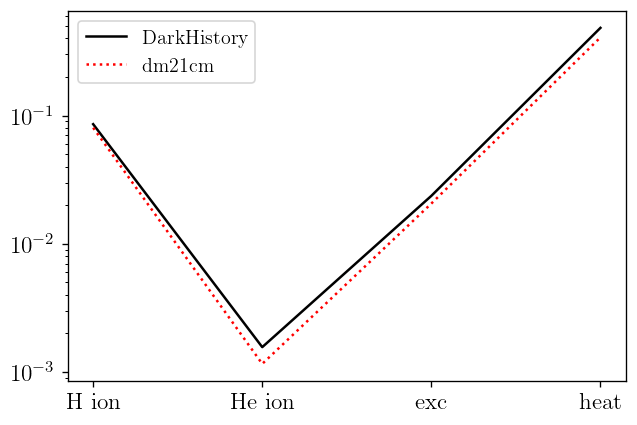

In [35]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL+1)

fig, ax = plt.subplots()

ax.plot(f_dh[:4], label='DarkHistory', color='k')
ax.plot(f_dc[:4], label='dm21cm', color='r', ls=':')
ax.set_xticks(np.arange(4))
ax.set_xticklabels([s.decode('utf-8') for s in dc_dep_tf.abscs['out'][:4]])
ax.set(yscale='log')
#ax.set(ylim=(1e-7,1e-4))
ax.legend();

In [36]:
f_dc[:4] / f_dh[:4]

array([0.93774753, 0.74026269, 0.87090007, 0.84268368])

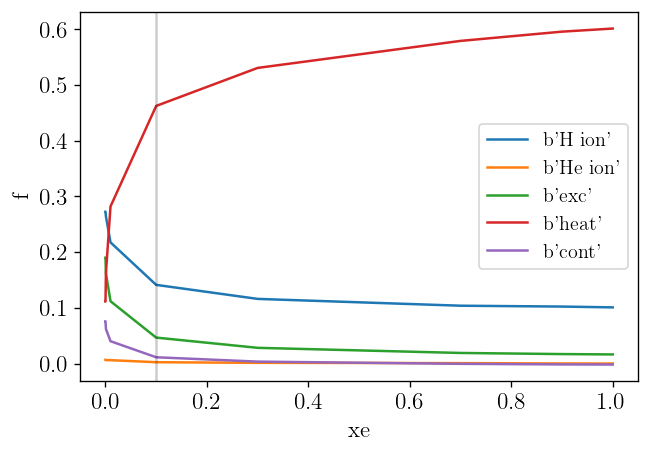

In [43]:
for i in range(5):
    plt.plot(dc_dep_tf.abscs['x'], dc_dep_tf.data[5, 314, 6, :, i] / (dc_dep_tf.abscs['Ein'][314]+phys.m_e), label=dc_dep_tf.abscs['out'][i])
plt.axvline(0.1, color='k', alpha=0.2)
plt.xlabel('xe')
plt.ylabel('f')
plt.legend()

In [23]:
dc_dep_tf.abscs['rs']

array([ 5.        ,  6.45774833,  8.34050269, 10.77217345, 13.91279701,
       17.96906832, 23.20794417, 29.97421252, 38.71318413, 50.        ])